# Ephemeris object imaging: continuum (mosaic) - use of updated ephemeris table from JPL-Horizons

This nootebook demonstlates continuum imaging of the ephemeris objects. 
In the following steps first we use the attached ephemeris table(s) 

In [9]:
# extra packages needed
#import os
#os.system('pip install astropy')
#os.system('pip install aplpy')

In [10]:
# import helper functions defined in 'Trackfield' mfs mosaic notebook
from ipynb.fs.defs.ephemimagingVenusMfsMosaicTrackfield import *

In [11]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat
from casatools import measures, quanta, table, image, msmetadata
import os
from astropy.io import fits
from matplotlib import pyplot
import pylab as pl
import aplpy
import shutil
me = measures()
qa = quanta()
tb = table()
ia = image()
msmd = msmetadata()

Define some useful funcitons
delete_tcleanimages: delete previous images from tclean run
get_attachedEphemtablepath: returns full eph table path for the corresponding field id

In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available.


In [12]:
datapath='/home/casa/data/casatestdata/measurementset/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [13]:
msfile='venus_ephem_test.ms'
if os.path.exists(msfile):
    os.system(f'cp -r {datapath}{msfile} {msfile}')

## Imaging with external ephemeris table
Following steps describes that imaging with updated ephemeris table which is different from one used to track the source during observation. In that case the source image will be centered using the updated eph table while the original internal eph table will be used for re-phasing during gridding.

In [14]:
imgname='mosaic-mfs-exteph-venus'

In [15]:
delete_tcleanimages(imgname)

### Get ephemeris table from JPL-Horizons

In [16]:
# use the list obs
listobsout = listobs(msfile)
print(f'obs time: {listobsout["BeginTime"]} - {listobsout["EndTime"]}')
# Use the same interval as the attached ephemeris table 
inephemtab = get_attachedEphemtablepath(msfile,0)
tb.open(inephemtab)
dmjd = tb.getkeyword('dMJD')
tb.done()
# 0.0138888 day -> 20min

obs time: 58491.47346277778 - 58491.485248888894


True

In [17]:
interval = '20m'
# modify a larger time span that convers the observation to be safe
timerange='MJD 58491.0~58492.0'

In [18]:
getephemtable(objectname='Venus', timerange=timerange, interval=interval, outfile='Venus_JPL-Horizons_MJD58491.4.tab', overwrite=True)

2024-01-16 04:59:37	WARN	getephemtable::::casa	Venus_JPL-Horizons_MJD58491.4.tab exists, will be overwritten


query params= b'format=json&EPHEM_TYPE=OBSERVER&OBJ_DATA=YES&COMMAND=%27299%27&START_TIME=JD2458491.5&STOP_TIME=JD2458492.5&STEP_SIZE=20m&CENTER=500%40399&QUANTITIES=%271%2C14%2C15%2C17%2C19%2C20%2C24%27&ANG_FORMAT=DEG'


In [19]:
extephemtabpath=os.path.abspath('Venus_JPL-Horizons_MJD58491.4.tab')
print(extephemtabpath)

/export/home/murasame2/casadev/ephemimaging/demo/notebooks/Venus_JPL-Horizons_MJD58491.4.tab


Now do imaging using the external ephmeris table to stop the image 

In [20]:
ret=tclean(vis=datapath+msfile, field='Venus', imagename=imgname, imsize=[288, 288], cell=['0.14arcsec'], phasecenter=extephemtabpath, specmode='mfs', gridder='mosaic', usepointing=True, niter=100)
ret['iterdone']

refEp = Epoch: 58491::11:21:50.2080 : Direction: [-0.487349, -0.823017, -0.291777]
buildCoordSys : refCoord RA(rad) = 4.17776, Dec(rad) = -0.296084
2024-01-16 04:59:45	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.7951734662055969 at index [1, 156, 0, 0])


100

Convert a CASA image to FITS image for displaying the image via aplpy

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [21]:
# Find the path of the attached ephem. table for fieldid=0
#ephemtab = get_attachedEphemtablepath(msfile,0)
#print(ephemtab)

In [22]:
# Get the first time stamp 
msmd.open(msfile)
t0 = msmd.timesforfield(0)[0]
reftm=qa.quantity(t0,'s')

# find the direction of Venus at reftm
exteph_dir = ephem_dir(extephemtabpath, reftm, 'ALMA')
ineph_dir = ephem_dir(get_attachedEphemtablepath(msfile,0), reftm, 'ALMA')
print(exteph_dir)
print(ineph_dir)
exteph_rad = qa.convert(exteph_dir['m0'],'deg')
exteph_decd = qa.convert(exteph_dir['m1'],'deg')
extephmarker = {'extephem':{'ra':exteph_rad['value'], 'dec':exteph_decd['value']}}
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
inephmarker = {'inephem':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}
markers = {**inephmarker,**extephmarker}
print(markers)

{'m0': {'unit': 'rad', 'value': -2.1054024946923904}, 'm1': {'unit': 'rad', 'value': -0.29608880918771524}, 'refer': 'ICRS', 'type': 'direction'}
{'m0': {'unit': 'rad', 'value': -2.1053741432104243}, 'm1': {'unit': 'rad', 'value': -0.2960804428183449}, 'refer': 'ICRS', 'type': 'direction'}
{'inephem': {'ra': -120.62905270192907, 'dec': -16.964159769855666}, 'extephem': {'ra': -120.63067712218867, 'dec': -16.964639127510434}}


INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -2.923e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.975e+00 [aplpy.core]
ky=inephem
inephem at: 15:57:29.027, -016.57.50.975
ky=extephem
extephem at: 15:57:28.637, -016.57.52.701
image center: ('15:57:28.351', '-016.57.51.796')


<Figure size 1500x1500 with 0 Axes>

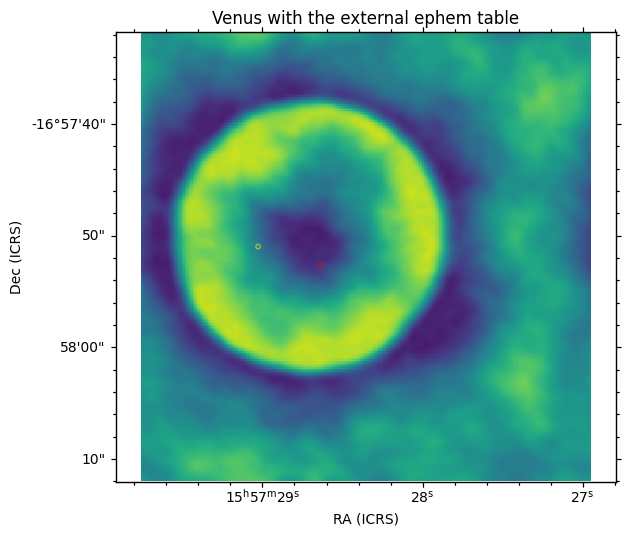

In [23]:
displayImage(imgname+'.residual', markers=markers, title='Venus with the external ephem table')

We can check the position shift is consistent with the ephemeris data used.
The first timestamp will be used in tclean to center the image.


In [24]:
from casatools import msmetadata
msmd = msmetadata()
msmd.open(datapath+msfile)
# first timestamp for field 0
t0 = qa.quantity(msmd.timesforfield(0)[0], 's')
msmd.close()
#t0 = qa.quantity(mjds[12],'d')
print(t0)
print(qa.time(t0,form='ymd'))

{'unit': 's', 'value': 5053663408.127999}
['2019/01/08/11:23:28']


In [27]:
#internal_ephem = me.framecomet(intabpath)

In [28]:
#me.doframe(me.observatory('ALMA'))
#me.doframe(me.epoch('utc', t0))
#internal_ephem_dir = me.measure(me.measure(me.direction('COMET'),'AZELGEO'),'ICRS')

In [30]:
print("internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9),qa.angle(ineph_dir['m1'],prec=9))
print("external ephem dir = ",qa.time(exteph_dir['m0'],prec=9),qa.angle(exteph_dir['m1'],prec=9))

internal ephem dir =  ['15:57:29.027'] ['-016.57.50.975']
external ephem dir =  ['15:57:28.637'] ['-016.57.52.701']
